# Using the data to make predictions

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg

from CurlingDB import CurlingDB
from utils.PlotnineElements import PlotnineElements as pe, blank

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Create Database Connection

In [14]:
db = CurlingDB(db_name='world_curling_ss.db')

# Adding a more accurate hammer colour to the database

## Get the hammer of each end

Methods to get the hammer
- If mens or womens teams then can try to grab the colour of the rock in the first frame
- If mixed doubles then can try to grab the majority from the first frame
- Else if no stone can be found in the first frame then backtrack one, then two ends to see if hammer can be determined by who scored most recently

### Get hammer info for a single game

In [4]:
# game = ('CU_WMCC2016P', 'SWE', 'JPN', 'Mens_Teams')
game = ('CUR_WWCC2017P', 'RUS', 'DEN', 'Womens_Teams')

In [5]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query, game)
false_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
false_colours

,end_id,end_num,db_hammer_colour,direction
0,148,1,yellow,down
1,149,2,yellow,up
2,150,3,yellow,up
3,151,4,red,down
4,152,5,yellow,up
5,153,6,red,up
6,154,7,yellow,down
7,155,8,red,down
8,156,9,yellow,down
9,157,10,yellow,up


In [6]:
# 'red' if the team1score - team2score > 0, 'yellow' if < 0, lag by one, orderby end_num, partition by match_id of colour
# teamscore is team_1_final_score - LAG(team_1_final_score) PARTITION BY match_id ORDER BY e.num
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams')
    AND
    p.frame_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query2, game)
pred_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
pred_colours

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,148,1,yellow,yellow,incon
1,149,2,yellow,yellow,incon
2,150,3,yellow,yellow,incon
3,151,4,red,red,red
4,152,5,yellow,yellow,yellow
5,153,6,yellow,yellow,yellow
6,154,7,red,red,red
7,155,8,yellow,yellow,yellow
8,156,9,yellow,yellow,yellow
9,157,10,red,red,red


In [7]:
pred_colours.drop(columns=['frame_based', 'prev_based']).merge(false_colours.drop(columns=['end_num', 'direction']), on='end_id')

,end_id,end_num,pred_hammer_colour,db_hammer_colour
0,148,1,yellow,yellow
1,149,2,yellow,yellow
2,150,3,yellow,yellow
3,151,4,red,red
4,152,5,yellow,yellow
5,153,6,yellow,red
6,154,7,red,yellow
7,155,8,yellow,red
8,156,9,yellow,yellow
9,157,10,red,yellow


### Hammer info for all ends

In [76]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    m.type IN ('Mens_Teams', 'Womens_Teams')
"""
db.execute_query(hammer_query)
false_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
false_colours

,end_id,end_num,db_hammer_colour,direction
0,1,1,red,down
1,2,2,yellow,up
2,3,3,red,up
3,4,4,yellow,down
4,5,5,yellow,up
...,...,...,...,...
11467,18178,6,yellow,up
11468,18179,7,red,down
11469,18180,8,red,down
11470,18181,9,red,down


In [77]:
# 'red' if the team1score - team2score > 0, 'yellow' if < 0, lag by one, orderby end_num, partition by match_id of colour
# teamscore is team_1_final_score - LAG(team_1_final_score) PARTITION BY match_id ORDER BY e.num
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        s.colour
        WHEN
            'red'
        THEN
            'yellow'
        WHEN
            'yellow'
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams')
    AND
    p.frame_num = 1
"""
db.execute_query(hammer_query2)
pred_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
pred_colours

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,1,1,incon,incon,incon
1,2,2,red,red,red
2,3,3,yellow,yellow,yellow
3,4,4,yellow,yellow,yellow
4,5,5,yellow,yellow,yellow
...,...,...,...,...,...
11467,18178,6,red,incon,red
11468,18179,7,yellow,incon,yellow
11469,18180,8,red,red,red
11470,18181,9,yellow,incon,yellow


### They agree on rougly 56% of ends, disagree on 42% and my new prediction has no idea for roughly 2%

In [78]:
all_colours = pred_colours.drop(columns=['frame_based', 'prev_based']).merge(false_colours.drop(columns=['end_num', 'direction']), on='end_id')
pd.DataFrame({'counts': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts(), 'perc': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts() / all_colours.shape[0] * 100})

counts       perc
pred_hammer_colour db_hammer_colour                   
yellow             yellow              3259  28.408298
red                red                 3192  27.824268
yellow             red                 2442  21.286611
red                yellow              2378  20.728731
incon              yellow               104   0.906555
                   red                   97   0.845537

### Try the same thing for mixed doubles, individual game

In [19]:
game = ('CU_WMDCC2016P', 'NZL', 'CAN', 'Mixed_Doubles')

In [31]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
"""
db.execute_query(hammer_query, game)
false_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
false_colours

,end_id,end_num,db_hammer_colour,direction
0,5053,1,red,down
1,5054,2,yellow,up
2,5055,3,yellow,up
3,5056,4,red,down
4,5057,5,yellow,up
5,5058,6,red,up
6,5059,7,red,down


In [65]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mixed_Doubles')
    AND
    p.frame_num = 1
    AND
    e2.abbrev = ?
    AND
    m.team_1 = ?
    AND
    m.team_2 = ?
    AND
    m.type = ?
GROUP BY 1
"""
db.execute_query(hammer_query2, game)
pred_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
pred_colours

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,5053,1,yellow,yellow,incon
1,5054,2,red,red,red
2,5055,3,yellow,yellow,yellow
3,5056,4,red,red,red
4,5057,5,yellow,yellow,yellow
5,5058,6,red,incon,red
6,5059,7,red,red,red


In [54]:
all_colours = pred_colours.drop(columns=[]).merge(false_colours.drop(columns=['end_num', 'direction']), on='end_id')
all_colours

,end_id,end_num,count,pred_hammer_colour,frame_based,prev_based,db_hammer_colour
0,5053,1,2,yellow,yellow,incon,red
1,5054,2,1,red,red,red,yellow
2,5055,3,2,yellow,yellow,yellow,yellow
3,5056,4,1,red,red,red,red
4,5057,5,2,yellow,yellow,yellow,yellow
5,5058,6,1,red,incon,red,red
6,5059,7,1,red,red,red,red


In [71]:
hammer_query = """
SELECT
    e.end_id,
    e.num,
    e.hammer_colour,
    e.direction
FROM 
    Throw t
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    t.throw_num = 1
    AND
    m.type = 'Mixed_Doubles'
"""
db.execute_query(hammer_query)
false_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'db_hammer_colour', 'direction'])
false_colours

,end_id,end_num,db_hammer_colour,direction
0,1790,1,yellow,down
1,1791,2,yellow,up
2,1792,3,red,up
3,1793,4,yellow,down
4,1794,5,red,up
...,...,...,...,...
5765,17834,3,yellow,up
5766,17835,4,yellow,down
5767,17836,5,yellow,up
5768,17837,6,red,up


In [72]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            CASE 
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    CASE
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            'incon'
                        END
                END
            END,
    CASE
        WHEN
            COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
        THEN
            'yellow'
        WHEN
            COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
        THEN
            'red'
        ELSE
            'incon'
        END,
    CASE 
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            > 0
        THEN
            'yellow'
        WHEN
            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
            < 0
        THEN
            'red'
        ELSE
            CASE
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    > 0
                THEN
                    'yellow'
                WHEN
                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                    < 0
                THEN
                    'red'
                ELSE
                    'incon'
                END
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mixed_Doubles')
GROUP BY 1
"""
db.execute_query(hammer_query2)
pred_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour', 'frame_based', 'prev_based'])
pred_colours

,end_id,end_num,pred_hammer_colour,frame_based,prev_based
0,1790,1,incon,incon,incon
1,1791,2,yellow,incon,yellow
2,1792,3,yellow,incon,yellow
3,1793,4,yellow,incon,yellow
4,1794,5,red,incon,red
...,...,...,...,...,...
5766,17834,3,yellow,incon,yellow
5767,17835,4,yellow,incon,yellow
5768,17836,5,yellow,incon,yellow
5769,17837,6,yellow,incon,yellow


### They agree on roughly 56% of ends, disagree on 30%, and new prediction is inconclusive on 13%

In [74]:
all_colours = pred_colours.drop(columns=['frame_based', 'prev_based']).merge(false_colours.drop(columns=['end_num', 'direction']), on='end_id')
pd.DataFrame({'counts': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts(), 'perc': all_colours[['pred_hammer_colour', 'db_hammer_colour']].value_counts() / all_colours.shape[0] * 100})

counts       perc
pred_hammer_colour db_hammer_colour                   
red                red                 1666  28.873484
yellow             yellow              1601  27.746967
                   red                  883  15.303293
red                yellow               842  14.592721
incon              yellow               400   6.932409
                   red                  378   6.551127

### Altogether now
- There may be a way to optimize the length of this command but I don't think it is necessary

In [60]:
hammer_query2 = """
SELECT
    e.end_id,
    e.num,
    CASE
        WHEN
            m.type = 'Mixed_Doubles'
        THEN
            CASE
                WHEN
                    COUNT(CASE s.colour WHEN 'red' THEN 1 ELSE NULL END) = 2
                THEN
                    'yellow'
                WHEN
                    COUNT(CASE s.colour WHEN 'yellow' THEN 1 ELSE NULL END) = 2
                THEN
                    'red'
                ELSE
                    CASE 
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            CASE
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    > 0
                                THEN
                                    'yellow'
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    < 0
                                THEN
                                    'red'
                                ELSE
                                    'incon'
                                END
                        END
                END
        WHEN
            m.type IN ('Mens_Teams', 'Womens_Teams', 'Mixed_Teams')
        THEN
            CASE
                s.colour
                WHEN
                    'red'
                THEN
                    'yellow'
                WHEN
                    'yellow'
                THEN
                    'red'
                ELSE
                    CASE 
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            > 0
                        THEN
                            'yellow'
                        WHEN
                            ((COALESCE(LAG(e.team_1_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                            (COALESCE(LAG(e.team_2_final_score, 1) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                            < 0
                        THEN
                            'red'
                        ELSE
                            CASE
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    > 0
                                THEN
                                    'yellow'
                                WHEN
                                    ((COALESCE(LAG(e.team_1_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_1_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)) -
                                    (COALESCE(LAG(e.team_2_final_score, 2) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0) - COALESCE(LAG(e.team_2_final_score, 3) OVER (PARTITION BY m.match_id ORDER BY e.end_id), 0)))
                                    < 0
                                THEN
                                    'red'
                                ELSE
                                    'incon'
                                END
                        END
                END
        ELSE
            'incon'
        END
FROM
    Stone s
RIGHT JOIN
    Position p
ON
    s.position_id = p.position_id
JOIN
    End e
ON
    p.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN 
    Event e2
ON
    m.event_id = e2.event_id
GROUP BY 1
"""
db.execute_query(hammer_query2)
pred_colours = pd.DataFrame(db.cursor.fetchall(), columns=['end_id', 'end_num', 'pred_hammer_colour'])
pred_colours

,end_id,end_num,pred_hammer_colour
0,1,1,yellow
1,2,2,red
2,3,3,yellow
3,4,4,yellow
4,5,5,yellow
...,...,...,...
18177,18178,6,yellow
18178,18179,7,red
18179,18180,8,red
18180,18181,9,red


In [61]:
pd.DataFrame({'counts': pred_colours[['pred_hammer_colour']].value_counts(), 'perc': pred_colours[['pred_hammer_colour']].value_counts() / pred_colours.shape[0] * 100})

,counts,perc
pred_hammer_colour,,
yellow,9445,51.946981
red,7959,43.774062
incon,778,4.278957


## Add new hammer colours to database

In [3]:
# Alter table command
add_hammer_pred = """
ALTER TABLE 
    End 
ADD 
    hammer_colour_alt TEXT
"""
# db.execute_query(add_hammer_pred)

## Populate field

In [62]:
add_hammer_pred_pop = """
UPDATE
    End
SET
    hammer_colour_alt = ?
WHERE
    end_id = ?
"""

In [63]:
populate_values = [(x[1], x[0]) for x in pred_colours.drop(columns='end_num').query('pred_hammer_colour != "incon"').itertuples(index=False, name=None)]
populate_values[:5]

[('yellow', 1), ('red', 2), ('yellow', 3), ('yellow', 4), ('yellow', 5)]

In [64]:
# db.execute_many(add_hammer_pred_pop, populate_values)

# Exploration

## Predicting winner from ratings of players

In [15]:
# Get the list of players from a team from a match
players_query = """
SELECT
    DISTINCT 
    m.match_id,
    p.name,
    p.team,
    CASE
        WHEN
            SUBSTR(p.team, 1, 3) = SUBSTR(m.team_1, 1, 3)
        THEN
            'team1'
        WHEN
            SUBSTR(p.team, 1, 3) = SUBSTR(m.team_2, 1, 3)
        THEN
            'team2'
        END

FROM 
    Player p
JOIN
    Throw t
ON
    p.player_id = t.player_id
JOIN
    End e
ON
    t.end_id = e.end_id
JOIN
    Match m
ON
    e.match_id = m.match_id
JOIN
    Event e2
ON
    m.event_id = e2.event_id
WHERE
    m.type IN ('Mens_Teams', 'Womens_Teams', 'Mixed_Teams')
"""
db.execute_command(players_query)
game_players = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'player', 'team', 'rel_team'])
game_players

,match_id,player,team,rel_team
0,1,FREDERICKS ARMSTR.,AUS,team2
1,1,THOMPSON H,NZL,team1
2,1,POWELL A,AUS,team2
3,1,JEYARANJAN T,NZL,team1
4,1,FORGE K,AUS,team2
...,...,...,...,...
11234,2165,DUFF H,SCO,team2
11235,2165,KIM H,KOR,team1
11236,2165,MACDONALD A,SCO,team2
11237,2165,KIM M,KOR,team1


In [16]:
# Get the ratings of all players
rating_query = """
SELECT
    p.name,
    p.team,
    COUNT(*),
    AVG(t.rating)
FROM 
    Player p
JOIN
    Throw t
ON
    p.player_id = t.player_id
JOIN
    End e
ON
    t.end_id = e.end_id
/*WHERE 
    p.name IN 
        (SELECT
            DISTINCT 
            p.name
        FROM 
            Player p
        JOIN
            Throw t
        ON
            p.player_id = t.player_id
        JOIN
            End e
        ON
            t.end_id = e.end_id
        JOIN
            Match m
        ON
            e.match_id = m.match_id
        JOIN
            Event e2
        ON
            m.event_id = e2.event_id
        WHERE m.match_id = 1)*/
GROUP BY
    1

"""
db.execute_command(rating_query)
player_ratings = pd.DataFrame(db.cursor.fetchall(), columns=['player', 'team', 'throw_count', 'mean_rating'])
player_ratings

,player,team,throw_count,mean_rating
0,110.3cm,Shoot-out,1,NaN
1,15.3cm,Shoot-out,1,NaN
2,17.1cm,Shoot-out,1,NaN
3,17.7cm,Shoot-out,1,NaN
4,199.6cm,Shoot-out,5,NaN
...,...,...,...,...
936,ZHOU Y,CHN,516,3.131783
937,ZHUZBAY A,KAZ,475,2.686316
938,ZIOLO T,POL,14,2.000000
939,ZOU D,CHN,431,3.000000


In [17]:
# Get the winning team for all matches
winner_query = """
SELECT
    m.match_id,
    CASE
        WHEN
            m.team_1_final_score > m.team_2_final_score
        THEN
            'team1'
        WHEN
            m.team_1_final_score < m.team_2_final_score
        THEN
            'team2'
        ELSE
            'draw'
        END
FROM 
    Match m
"""
db.execute_command(winner_query)
winner_list = pd.DataFrame(db.cursor.fetchall(), columns=['match_id', 'winner'])
winner_list.set_index('match_id')

,winner
match_id,
1,team1
2,team2
3,team1
4,team2
5,team1
...,...
2161,team1
2162,team2
2163,team2


### Combine the players from the games with their ratings

In [18]:
# Find all matches with 8 players listed
complete_matches = game_players.groupby('match_id')['player'].count().where(lambda x: x == 8).dropna().index.values
# Filter the matches and players by the above list
game_players = game_players[game_players.match_id.isin(complete_matches)].reset_index(drop=True)
# Combine the players with their ratings
game_players = game_players.merge(player_ratings, how='left')
# Identify the player/team of the player and add column
game_players = game_players.sort_values(['match_id', 'rel_team', 'mean_rating']).reset_index(drop=True)
game_players['player_iden'] = game_players.apply(lambda x: f"player_{x.name % 8}", axis=1)
#.reset_index(drop=True).reset_index().apply(lambda x: f"player_{x['index'] % 8}", axis=1)
game_players.head(30)

,match_id,player,team,rel_team,throw_count,mean_rating,player_iden
0,1,THOMPSON H,NZL,team1,40.0,1.950000,player_0
1,1,BECKER B,NZL,team1,417.0,2.429257,player_1
2,1,JEYARANJAN T,NZL,team1,58.0,2.534483,player_2
3,1,SMITH J,NZL,team1,58.0,2.706897,player_3
4,1,WILLIAMS H,AUS,team2,40.0,1.950000,player_4
5,1,FREDERICKS ARMSTR.,AUS,team2,40.0,2.150000,player_5
6,1,POWELL A,AUS,team2,40.0,2.350000,player_6
7,1,FORGE K,AUS,team2,40.0,2.500000,player_7
8,2,YOSHIDA C,JPN,team1,647.0,2.434312,player_0
9,2,FUJISAWA S,JPN,team1,933.0,2.523044,player_1


### Reformat as features, 0-3 are team1, 4-7 are team2

In [19]:
data = game_players.pivot_table(index='match_id', columns='player_iden', values='mean_rating').dropna()
data = data.merge(winner_list, left_index=True, right_index=True)
data

,player_0,player_1,player_2,player_3,player_4,player_5,player_6,player_7,match_id,winner
1,1.950000,2.429257,2.534483,2.706897,1.950000,2.150000,2.350000,2.500000,2,team2
2,2.434312,2.523044,2.569444,3.234043,2.499278,2.618915,3.138889,3.231293,3,team1
3,2.738854,2.750000,2.800786,2.850829,2.445545,2.668142,3.057851,3.363248,4,team2
4,2.809697,2.964628,2.979339,3.019022,3.051587,3.063518,3.117188,3.285714,5,team1
5,2.878205,2.891026,2.931667,3.166209,2.963874,3.122929,3.194154,3.250522,6,team1
...,...,...,...,...,...,...,...,...,...,...
2160,2.616379,2.657407,2.904762,2.981481,2.987342,3.035461,3.121875,3.250000,2161,team1
2161,2.987342,3.035461,3.121875,3.250000,2.895833,2.978947,3.020833,3.083333,2162,team2
2162,2.626263,2.745283,3.219388,3.383333,2.895833,2.978947,3.020833,3.083333,2163,team2
2163,2.895833,2.978947,3.020833,3.083333,2.788462,2.815789,3.000000,3.166667,2164,team1


### Create train/test split

In [20]:
from sklearn.model_selection import train_test_split

features = [f"player_{x}" for x in range(8)]
target = 'winner'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], train_size=0.8)

### There is some room to remove features but 8 features isn't too many so we'll stick with it

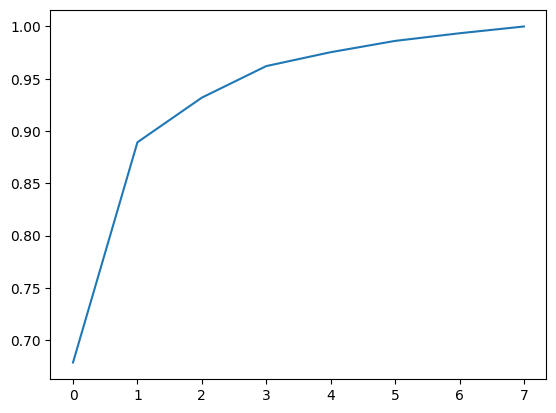

In [21]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

## SVC

In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC()
svc.fit(X_train, y_train)

SVC()

In [27]:
pred = svc.predict(X_test)
f"Accuracy: {sum((pred == y_test)) / len(pred)}"

'Accuracy: 0.4845814977973568'

## Random Forest

In [81]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [10, 100, 500], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [7, 9, 12]}
rfcgs = GridSearchCV(RandomForestClassifier(), params)
rfc = RandomForestClassifier(n_estimators=1000)
rfcgs.fit(X_train, y_train)

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [7, 9, 12],
                         'n_estimators': [10, 100, 500]})

In [79]:
rfcgs.best_params_

{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 500}

In [80]:
pred = rfcgs.predict(X_test)
f"Accuracy: {sum((pred == y_test)) / len(pred)}"

'Accuracy: 0.44493392070484583'

## Logistic Regression

In [92]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lrsc = make_pipeline(StandardScaler(), LogisticRegression())
lrsc.fit(X_train, y_train)
lr = LogisticRegression()
lr.fit(X_train, y_train)

/Users/lucasnieuwenhout/miniforge3/envs/env_curling/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [93]:
pred = lrsc.predict(X_test)
f"Accuracy: {sum((pred == y_test)) / len(pred)}"

'Accuracy: 0.4008810572687225'

In [94]:
pred = lr.predict(X_test)
f"Accuracy: {sum((pred == y_test)) / len(pred)}"

'Accuracy: 0.3920704845814978'

# SGD Classifier

In [95]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier()
sgdc.fit(X_train, y_train)

SGDClassifier()

In [96]:
pred = sgdc.predict(X_test)
f"Accuracy: {sum((pred == y_test)) / len(pred)}"

'Accuracy: 0.46255506607929514'

In [100]:
sgdc.loss_functions

{'hinge': (sklearn.linear_model._sgd_fast.Hinge, 1.0),
 'squared_hinge': (sklearn.linear_model._sgd_fast.SquaredHinge, 1.0),
 'perceptron': (sklearn.linear_model._sgd_fast.Hinge, 0.0),
 'log_loss': (sklearn.linear_model._sgd_fast.Log,),
 'log': (sklearn.linear_model._sgd_fast.Log,),
 'modified_huber': (sklearn.linear_model._sgd_fast.ModifiedHuber,),
 'squared_error': (sklearn.linear_model._sgd_fast.SquaredLoss,),
 'huber': (sklearn.linear_model._sgd_fast.Huber, 0.1),
 'epsilon_insensitive': (sklearn.linear_model._sgd_fast.EpsilonInsensitive,
  0.1),
 'squared_epsilon_insensitive': (sklearn.linear_model._sgd_fast.SquaredEpsilonInsensitive,
  0.1)}